In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from tqdm import tqdm


from src import scale_proportional
from src import binary, otsu, watershed, region_growing
import src.description as description

In [2]:
# !curl -o dataset.zip "https://database.cric.com.br/api/v1/imagens/export?collection=1&images=1&classifications=0&segmentations=0"
# !mkdir -p dataset
# !unzip -q dataset.zip -d dataset

In [3]:
df = pd.read_csv('./classifications.csv')
dir_path = './dataset'
test_img = '0a2a5a681410054941cc56f51eb8fbda.png'
df[df['image_filename'] == test_img]

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
5635,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5636,Negative for intraepithelial lesion,1012,875
5636,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5637,Negative for intraepithelial lesion,910,900
5637,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5638,Negative for intraepithelial lesion,1177,416
5638,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5639,Negative for intraepithelial lesion,1254,366
5639,164,0a2a5a681410054941cc56f51eb8fbda.png,10.6084/m9.figshare.12230102,5640,LSIL,983,450


In [4]:
def crop_image_around_point(image, x, y, crop_size):
    # Calculate the top-left corner of the crop
    x_start = max(0, x - int(crop_size / 2))
    y_start = max(0, y - int(crop_size / 2))

    # Calculate the bottom-right corner of the crop
    x_end = min(image.shape[1], x + int(crop_size / 2))
    y_end = min(image.shape[0], y + int(crop_size / 2))

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    return cropped_image

In [5]:
def crop_with_pil(image, x, y, crop_size):
    lcrop = int(crop_size/2)
    rcrop = int(crop_size - lcrop)
    width, height = image.size

    # Calculate the top-left corner of the crop
    x_start = max(0, x - lcrop)
    y_start = max(0, y - lcrop)

    # Calculate the bottom-right corner of the crop
    x_end = min(width, x + rcrop)
    y_end = min(height, y + rcrop)

    # Crop the image
    cropped_image = image.crop((x_start, y_start, x_end, y_end))

    return cropped_image

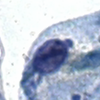

In [6]:
img_path = os.path.join(dir_path, test_img)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_img = crop_image_around_point(image, 1012, 875, 100)
img = Image.fromarray(cropped_img)
img

In [111]:
neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]  # 4-connectivity

# Create a mask to store segmented region
height, width, _ = cropped_img.shape
segmented = np.zeros_like(cropped_img, dtype=np.uint8)

seed = (height//2, width//2)
queue = [seed]

# Get the color of the seed pixel
seed_color = cropped_img[seed[0], seed[1]]

while queue:
    current_pixel = queue.pop(0)
    x, y = current_pixel

    # Check if the current pixel is within the image boundaries
    if 0 <= x < height and 0 <= y < width:
        # Check if the pixel has not been visited and has a similar color to the seed

        if np.all(segmented[x, y] == 0) and np.all(np.abs(cropped_img[x, y].astype(np.int64) - seed_color.astype(np.int64)) < [20, 20, 20]):
            # Add the current pixel to the segmented region
            segmented[x, y] = cropped_img[x, y]
            # segmented[x, y] = (255,255,255)

            # Add neighbors to the queue for further processing
            for neighbor in neighbors:
                queue.append((x + neighbor[0], y + neighbor[1]))
        # else:
        #     print(current_pixel, cropped_img[x, y], seed_color, cropped_img[x, y].astype(np.int64) - seed_color.astype(np.int64), np.any(np.abs(cropped_img[x, y] - seed_color) < [20, 20, 20]))

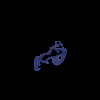

In [112]:
Image.fromarray(segmented)

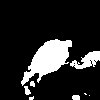

In [8]:
binary = binary(cropped_img, 127, invert=True)
Image.fromarray(binary)

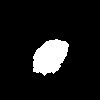

In [7]:
watershed_img = watershed(cropped_img)
Image.fromarray(watershed_img)

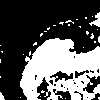

In [10]:
Image.fromarray(otsu(cropped_img, invert=True))

In [8]:
description.calculate_eccentricity(watershed_img)

0.5641397645686083

In [7]:
crop_size = 100
out_dir = './cropped_dataset/'

df = pd.DataFrame(columns=['image', 'area', 'compactness', 'eccentricity', 'permieter', 'label'])
error_log = []
for dir in (os.listdir(out_dir)):
    for file in tqdm(os.listdir(out_dir + "/" + dir)):
        try:
            path = (out_dir + dir + "/" + file)

            img = cv2.imread(path)
            test = region_growing(img)
            test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
            (x, y) = test.shape

            main_obj = test[x//2, y//2]

            test[test != main_obj] = 0
            test[test == main_obj] = 255

            df.loc[len(df.index)] = ((path, 
                description.calculate_area(test),
                description.calculate_compactness(test),
                description.calculate_eccentricity(test),
                description.calculate_perimeter(test), 
            dir))
        except:
            print(f'error: {path}')
            error_log.append(path)
df.to_csv('./main_data.csv')

 31%|███▏      | 290/925 [00:24<00:19, 32.40it/s]

error: ./cropped_dataset/ASC-H/8116.jpg


 89%|████████▊ | 820/925 [01:44<00:06, 15.28it/s]

error: ./cropped_dataset/ASC-H/9781.jpg


 73%|███████▎  | 443/606 [01:06<00:26,  6.15it/s]

error: ./cropped_dataset/ASC-US/4950.jpg


 42%|████▏     | 565/1360 [00:42<01:20,  9.90it/s]

error: ./cropped_dataset/LSIL/2507.jpg


 69%|██████▊   | 934/1360 [01:19<00:25, 16.54it/s]

error: ./cropped_dataset/LSIL/4639.jpg


 85%|████████▌ | 1162/1360 [01:37<00:10, 18.75it/s]

error: ./cropped_dataset/LSIL/5525.jpg


  0%|          | 27/6779 [00:00<02:19, 48.49it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/10048.jpg
error: ./cropped_dataset/Negative for intraepithelial lesion/10050.jpg


  6%|▌         | 376/6779 [00:12<03:49, 27.86it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/10505.jpg


 18%|█▊        | 1188/6779 [00:41<02:04, 44.82it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/11338.jpg


 30%|███       | 2064/6779 [01:16<01:52, 42.00it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/2338.jpg
error: ./cropped_dataset/Negative for intraepithelial lesion/2351.jpg


 31%|███       | 2086/6779 [01:17<01:54, 41.14it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/2365.jpg


 36%|███▌      | 2439/6779 [01:31<02:06, 34.22it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/2864.jpg


 37%|███▋      | 2502/6779 [01:34<02:52, 24.81it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/2944.jpg


 42%|████▏     | 2831/6779 [01:48<02:37, 25.14it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/3379.jpg


 45%|████▌     | 3080/6779 [01:58<01:42, 35.93it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/3679.jpg


 46%|████▋     | 3141/6779 [02:00<02:03, 29.44it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/3744.jpg


 48%|████▊     | 3241/6779 [02:06<02:00, 29.44it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/3869.jpg


 49%|████▊     | 3300/6779 [02:08<02:09, 26.97it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/3945.jpg


 55%|█████▍    | 3701/6779 [02:21<01:40, 30.63it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/4490.jpg


 55%|█████▍    | 3720/6779 [02:21<01:18, 39.04it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/4607.jpg
error: ./cropped_dataset/Negative for intraepithelial lesion/4611.jpg
error: ./cropped_dataset/Negative for intraepithelial lesion/4618.jpg


 56%|█████▌    | 3792/6779 [02:23<01:29, 33.55it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/4708.jpg


 57%|█████▋    | 3835/6779 [02:25<01:55, 25.40it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/4750.jpg


 59%|█████▉    | 4014/6779 [02:32<01:31, 30.12it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/4974.jpg


 63%|██████▎   | 4271/6779 [02:45<02:27, 17.03it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/5452.jpg


 67%|██████▋   | 4509/6779 [02:55<00:46, 48.30it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/5781.jpg


 74%|███████▎  | 4993/6779 [03:09<00:36, 49.06it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/6255.jpg


 80%|███████▉  | 5400/6779 [03:20<00:37, 36.53it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/6661.jpg


 82%|████████▏ | 5563/6779 [03:24<00:31, 38.99it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/6822.jpg


 82%|████████▏ | 5574/6779 [03:24<00:34, 34.71it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/6829.jpg


 84%|████████▍ | 5683/6779 [03:27<00:42, 25.93it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/6930.jpg


 84%|████████▍ | 5720/6779 [03:28<00:30, 34.44it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/6962.jpg


 85%|████████▌ | 5778/6779 [03:31<00:31, 32.22it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7010.jpg
error: ./cropped_dataset/Negative for intraepithelial lesion/7011.jpg


 85%|████████▌ | 5790/6779 [03:31<00:44, 22.08it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7026.jpg


 86%|████████▌ | 5805/6779 [03:32<00:29, 33.29it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7038.jpg


 87%|████████▋ | 5897/6779 [03:36<00:26, 32.94it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7120.jpg


 87%|████████▋ | 5905/6779 [03:36<00:29, 29.57it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7132.jpg


 90%|████████▉ | 6091/6779 [03:43<00:19, 36.14it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7303.jpg
error: ./cropped_dataset/Negative for intraepithelial lesion/7310.jpg


 91%|█████████ | 6162/6779 [03:44<00:11, 52.69it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/7376.jpg


 96%|█████████▌| 6495/6779 [03:56<00:08, 35.24it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/8196.jpg


 98%|█████████▊| 6640/6779 [04:00<00:03, 39.45it/s]

error: ./cropped_dataset/Negative for intraepithelial lesion/9608.jpg


100%|██████████| 161/161 [00:07<00:00, 21.69it/s]


In [38]:
df = pd.read_csv('./main_data.csv')
df = df.drop(df.columns[[0]], axis=1)

In [8]:
error_log

['./cropped_dataset/ASC-H/8116.jpg',
 './cropped_dataset/ASC-H/9781.jpg',
 './cropped_dataset/ASC-US/4950.jpg',
 './cropped_dataset/LSIL/2507.jpg',
 './cropped_dataset/LSIL/4639.jpg',
 './cropped_dataset/LSIL/5525.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/10048.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/10050.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/10505.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/11338.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/2338.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/2351.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/2365.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/2864.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/2944.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/3379.jpg',
 './cropped_dataset/Negative for intraepithelial lesion/3679.jpg',
 './cropped_dataset/Negative for intrae

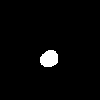

In [405]:
# img = cv2.imread(path)
path = error_log[45]
img = cv2.imread(path)

# img = otsu(img, invert=True)
# _, markers = cv2.connectedComponents(img)
# (x, y) = img.shape
# main_obj = markers[x//2-10, y//2-10]
# img[markers != main_obj] = 0
# img[markers == main_obj] = 255

img = watershed(img)
# (x, y) = img.shape
# main_obj = img[(x//2), (y//2)] #main_obj = 170
# img[img != main_obj] = 0
# img[img == main_obj] = 255

# img = region_growing(img, seed=(30,40))

# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Image.fromarray(img)

In [406]:
path

'./cropped_dataset/Negative for intraepithelial lesion/9608.jpg'

In [401]:
df.loc[len(df.index)] = ((path, 
    description.calculate_area(img),
    description.calculate_compactness(img),
    description.calculate_eccentricity(img),
    description.calculate_perimeter(img), 
"Negative for intraepithelial lesion"))

In [403]:
df.tail()

,image,area,compactness,eccentricity,permieter,label
11529,./cropped_dataset/Negative for intraepithelial...,470,1.127330,0.478484,81.597979,Negative for intraepithelial lesion
11530,./cropped_dataset/Negative for intraepithelial...,327,1.050396,0.413155,65.698484,Negative for intraepithelial lesion
11531,./cropped_dataset/Negative for intraepithelial...,261,1.027138,0.314594,58.041630,Negative for intraepithelial lesion
11532,./cropped_dataset/Negative for intraepithelial...,835,1.574316,0.643762,128.526911,Negative for intraepithelial lesion
11533,./cropped_dataset/Negative for intraepithelial...,247,1.033110,0.423945,56.627416,Negative for intraepithelial lesion


In [404]:
df.to_csv('./main_data.csv')

In [22]:
# Example usage:
# Load your image (replace 'your_image_path.jpg' with your actual image file path)
original_image = cv2.imread(img_path)

if original_image is None:
    print("erro")
else:
    # Replace these values with the actual x, y coordinates and the desired crop size
    center_x = 1254
    center_y = 366
    crop_size = 100

    # Crop the image around the specified x, y coordinates
    cropped_image = crop_image_around_point(original_image, center_x,  center_y, crop_size)

    # Display the original and cropped images
    cv2.imwrite('./tests/ouput.png', cropped_image)


In [96]:
def region_growing(image, seed=None, return_binary=True, threshold=[25,25,25]):
    """region_growing

    Args:
        image: image to be segmented
        seed (tuple, optional): seed from which growing will start. Defaults to None.
        return_binary (bool, optional): if false return the actual pixel of the image instead of a white. Defaults to True.
        threshold (list, optional): thresh array of max absolute difference in each colour spectrum. Defaults to [20,20,20].

    Returns:
        np.ndarray: image segemented
    """
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]  # 4-connectivity

    height, width, _ = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)

    if seed == None:
        seed = (height//2, width//2)

    queue = [seed]
    seed_color = image[seed[0], seed[1]]

    while queue:
        current_pixel = queue.pop(0)
        x, y = current_pixel
        if 0 <= x < height and 0 <= y < width:
            if np.all(segmented[x, y] == 0) and np.all(np.abs(image[x, y].astype(np.int64) - seed_color.astype(np.int64)) < threshold):
                if return_binary == True:
                    segmented[x, y] = (255,255,255)
                else:
                    segmented[x, y] = image[x, y]
                for neighbor in neighbors:
                    queue.append((x + neighbor[0], y + neighbor[1]))
    
    return segmented